# Скачивание и подготовка данных

In [ ]:
!pip install pyreadstat
!pip install catboost

In [ ]:
import pandas as pd
import re
import pyreadstat
import numpy as np

In [ ]:
df, meta = pyreadstat.read_sav('data.sav', apply_value_formats = True)
map_columns = meta.column_names_to_labels
maybe_leak = [
                 'xj10', 'xj10.2', 'xj15',
                 'xj238', 'xj39', 'xj40',
                 'xj57', 'xj89', 'xj13.2',
]
needed = [
    'idind', 'psu', 'site', 'status', 'popul', 
    'x_int_y', 'x_born_m', 'x_educ',  'x_diplom', 
    'x_age', 'region', 'xh5', 'xh6', 'xh7.1',
    'xh7.2', 'xh8a', 'xh8b', 'xi1', 'xi2',
    'xi3', 'xi7', 'xi8', 'xi4', 'xi3.1',
    'xj1', 'xj1.1.1', 'xj1.1.2', 'xj1.1.3',
    'xj1.1.4', 'xj2cod08', 'xj4.1', 'xj5a',
    'xj5b', 'xj6', 'xj6.0', 'xj6.1a', 'xj6.1b',
    'xj6.2', 'xj7', 'xj7.1', 'x_adult', 'xj8',
    'xj8.1', 'xj8.2', 'xj8.3', 'xj9', 'xj10', 'xj10.3',
    'xj10.2', 'xj11', 'xj11.1', 'xj11.2', 'xj13',
    'xj13.2', 'xj14', 'xj15', 'xj16', 'xj18.2', 
    'xj19', 'xj21a', 'xj21b', 'xj21.3', 'xj24', 
    'xj25', 'xj26', 'xj29', 'xj29c.1', 'xj29c.2',
    'xj22', 'xj31', 'xj29.1', 'xj29.2.1', 'xj29.2.2',
    'xj29.2.3', 'xj32', 'xj41.1', 'xj41.2', 'xj49', 
    'xj50', 'xj51', 'xj52', 'xj56', 'xj56.11c08',
    'xj56.12c08', 'xj56.13c08', 'xj57', 'xj58',
    'xj58.1', 'xj59', 'xj59.1', 'xj60', 'xj60.4a1',
    'xj60.5a'  'xj61', 'xj62', 'xj63', 'xj64',
    'xj65', 'xj66', 'xj66.1', 'xj69.9c', 'xj70.1', 'xj70', 
    'xj70.2', 'xk3.1', 'xj71', 'xj72.1a', 'xj72.1b', 
    'xj721dac08', 'xj72.1c', 'xj72.2a', 'xj72.2b', 
    'xj722dac08', 'xj72.2c', 'xj72.5a',
    'xj72.5b', 'xj725dac08',  'xj72.5c', 
    'xj72.5e', 'xj72.5h', 'xj72.5j',
    'xj72.18a', 'xj60.1',  'xj77',
    'xj260', 'xj262', 'xj322', 'xj324', 'xj72.171',
    'xj72.172', 'xj72.173', 'xj721635', 'xj721636',
    'xj73', 'xj81', 'xj81.2', 'xj81.1', 'xj83.1', 'xl20'
   ]

In [ ]:
map_numeric = {key: value for key, value in map_columns.items() if re.search(r'\bсколько\b', value.lower())}
columns_numeric = [x for x in map_numeric.keys()] + [
                                        'xj13.2', 'x_int_y', 'x_age', 
                                        'site', 'xh8b', 'popul',
                                        'xh8a', 'idind', 'xh7.1'  
] + ['xh6', 'xi8', 'xj69.9c', 'xj72.5e', 'xi7', 'xj5a']
df_numeric = df[[x for x in columns_numeric if x in set(needed)]]

In [ ]:
map_categorical = {el : map_columns[el] for el in set(map_columns) - set(map_numeric)}
columns_categorical = set([x for x in map_categorical.keys()]) - set(columns_numeric)
df_categorical = df[[x for x in columns_categorical if x in set(needed)]]

In [ ]:
df_ok_num = df_numeric[df_categorical['xj11.1'].notna()].reset_index(drop=True)
df_ok_cat = df_categorical[df_categorical['xj11.1'].notna()].reset_index(drop=True)
print(df_ok_num.shape)
cat_features = df_ok_cat.columns

for col in df_ok_num:
  df_ok_num[col] = df_ok_num[col].astype(object)

for col in df_ok_cat:
  df_ok_cat[col] = df_ok_cat[col].astype(object)

df_ok_num = df_ok_num.fillna(-1)
df_ok_cat = df_ok_cat.fillna('Unknown')

In [ ]:
def replace_non_numerical_answers_with_zero(column):
  for i, cell in enumerate(column):
    if isinstance(cell, str):
      column[i] = 0
  return column.astype(float)

df_ok_num = df_ok_num.apply(replace_non_numerical_answers_with_zero, axis=0)

In [ ]:
def make_str(col):
  for i in range(len(col)):
    col[i] = str(col[i])
  return col

df_ok_cat[['xj62', 'xj64', 'xj63', 'xk3.1']] = df_ok_cat[['xj62', 'xj64', 'xj63', 'xk3.1']].apply(make_str, axis=1)

In [ ]:
data = pd.concat([df_ok_num, df_ok_cat], axis=1)

# Обучение модели

In [ ]:
target = data['xj11.1']
cols = ['xj41.1', 'xj11.1'] + ['xj11.2', 'xj10.3', 'xj21a', 'xj21b']
features = data.drop(cols, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test, test_size=0.5
)
cat_features = set(cat_features) - set(['xj41.1', 'xj11.1', 'xj11.2', 'xj10.3', 'xj21a', 'xj21b'])
train_pool = Pool(features_train, target_train, cat_features=cat_features)
val_pool = Pool(features_valid, target_valid, cat_features=cat_features)
test_pool = Pool(features_test, target_test, cat_features=cat_features)

In [ ]:
model = CatBoostClassifier(verbose=100, iterations=300)#, depth=2, iterations=5000, learning_rate=4*0.068786)#, use_best_model=False)# boosting_type='Ordered')
model.fit(train_pool, eval_set=val_pool)

Learning rate set to 0.174585
0:	learn: 1.1050078	test: 1.1016838	best: 1.1016838 (0)	total: 145ms	remaining: 43.5s
100:	learn: 0.1590995	test: 0.2203981	best: 0.2203458 (90)	total: 1m 16s	remaining: 2m 31s
200:	learn: 0.1134326	test: 0.2191584	best: 0.2187897 (199)	total: 2m 41s	remaining: 1m 19s
299:	learn: 0.0871924	test: 0.2185792	best: 0.2173211 (286)	total: 4m 5s	remaining: 0us

bestTest = 0.2173210714
bestIteration = 286

Shrink model to first 287 iterations.


In [ ]:
from sklearn.metrics import accuracy_score
import random
print(accuracy_score(target_test, model.predict(test_pool)))
print(accuracy_score(target_test, [random.choice(target_test.unique()) for x in target_test]))

0.9228295819935691
0.33440514469453375


# Интерпретация результатов

In [ ]:

feat_imp =  model.get_feature_importance(prettified=True)

feat_imp.head(10)

,Feature Id,Importances
0,xj25,6.440438
1,xj13,5.851299
2,xj4.1,5.705283
3,xj5a,4.800941
4,xj2cod08,3.933418
5,xj8,3.839535
6,xj13.2,2.547536
7,xj60,2.419076
8,xj721635,2.204611
9,site,2.112135


In [ ]:
for x in feat_imp.head(10)['Feature Id']:
  print(x, map_columns[x])

xj25 Являются владельцами или совладельцами Вашего предприятия, организации какие-то российские частные лица, коллектив предприятия или российские частные фирмы?
xj13 Сколько человек работает на Вашем предприятии? Если не знаете точно, скажите примерно
xj4.1 В какой отрасли Вы работаете на этой работе?
xj5a С какого года Вы работаете на этом предприятии, на этой работе? Если Вы увольнялись и снова возвращались на это же предприятие, на эту работу, назовите дату последнего возвращения
xj2cod08 Код профессии по ISCO2008 основной работы
xj8 Сколько часов Вы фактически отработали по основному месту работы в течение последних 30 дней?
xj13.2 За последние 12 месяцев какова была Ваша среднемесячная зарплата на этом предприятии после вычета налогов - независимо от того, платят Вам ее вовремя или нет?
xj60 Сколько всего денег в течение последних 30 дней Вы лично получили, считая все: зарплату, пенсии, премии, прибыли, пособия, материальную помощь, случайные заработки и другие денежные поступлен

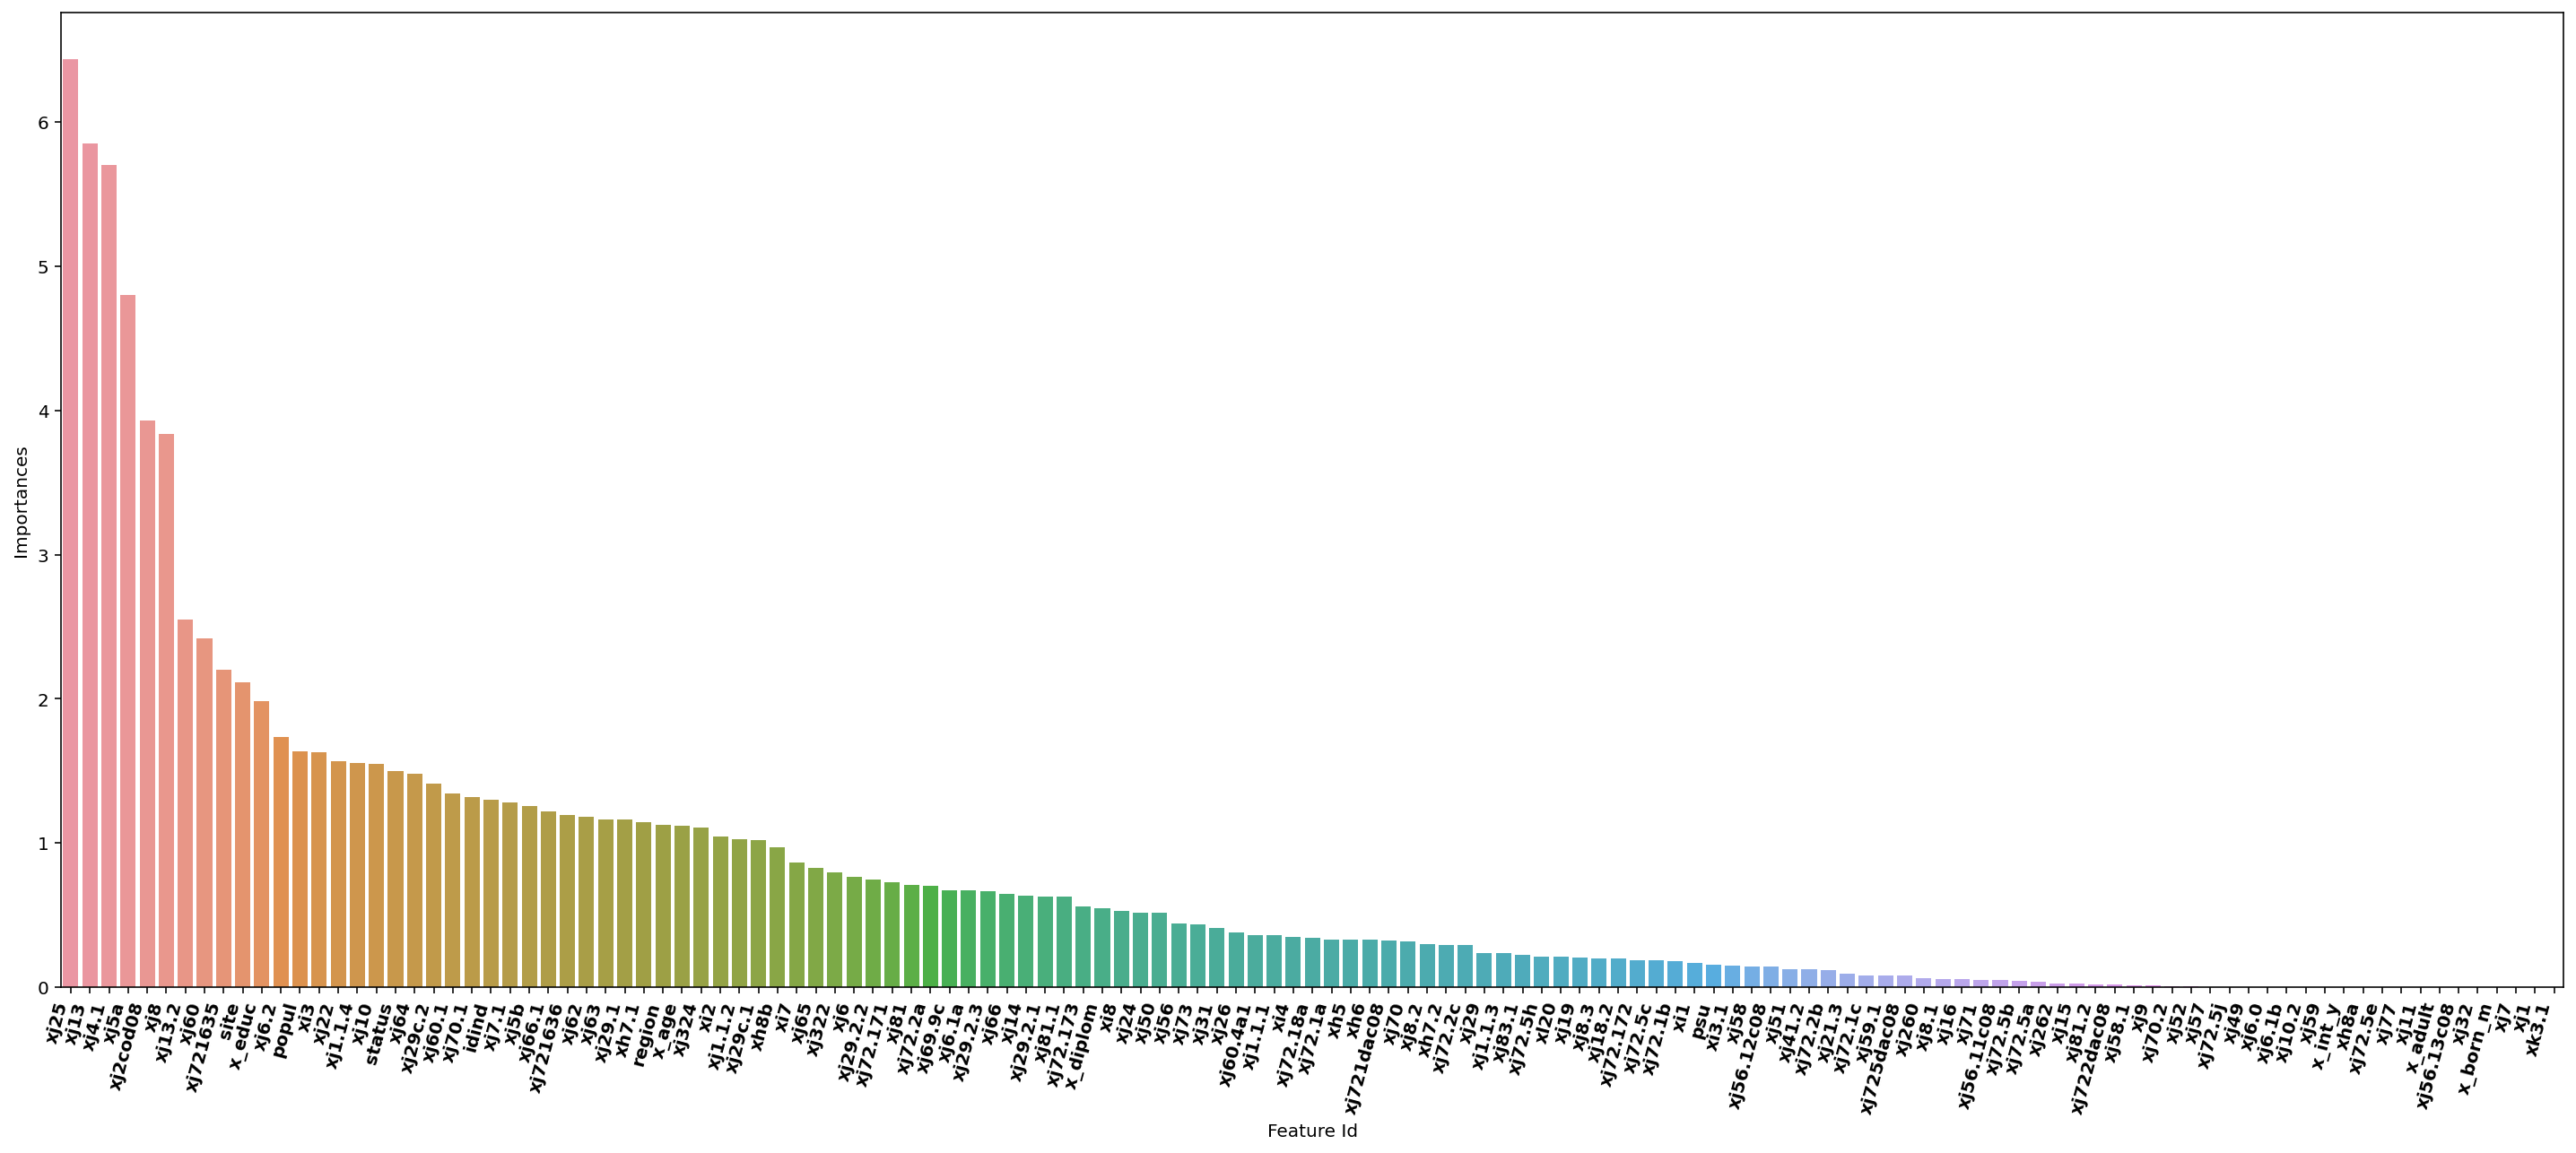

In [ ]:
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize']=(25,10)

sns.barplot(x='Feature Id', y='Importances', data=feat_imp)
bars = feat_imp['Feature Id']
y_pos = np.arange(131)
plt.xticks(y_pos, bars, rotation=75, fontweight='bold',
           fontsize='10', horizontalalignment='right')
plt.show()